In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")
# pd.options.display.float_format = '{:.4%}'.format

In [2]:
df = pd.read_csv('./data/SP500stocks.csv',index_col='date',parse_dates=True)

In [3]:
df

APA        BEN        DVN        FCX        HAL        MOS  \
date                                                                           
2010-01-04  79.975365  20.685516  50.045765  30.208916  24.500385  47.799934   
2010-01-05  80.919579  20.846413  50.098061  30.389898  24.813995  48.915367   
2010-01-06  82.188690  20.861732  49.947723  31.602436  25.402000  50.789871   
2010-01-07  80.942238  20.674044  49.653595  30.997980  25.464718  50.937050   
2010-01-08  80.519226  20.695108  49.751640  31.888384  26.750498  51.665157   
...               ...        ...        ...        ...        ...        ...   
2025-05-13  18.459999  21.580000  34.290001  39.470001  21.309999  34.230000   
2025-05-14  18.170000  22.010000  33.959999  39.060001  21.230000  33.680000   
2025-05-15  17.760000  22.180000  33.400002  38.470001  21.040001  34.669998   
2025-05-16  17.590000  22.379999  33.259998  38.020000  21.250000  35.209999   
2025-05-19  17.320000  22.209999  32.689999  38.799999  20.870001  35.349998   

                  NEM        OXY        SLB        WBA  
date                                                    
2010-01-04  34.596298  51.517189  46.920071  22.702435  
2010-01-05  34.689133  51.145222  47.052921  22.519842  
2010-01-06  35.424625  51.758945  48.101635  22.349422  
2010-01-07  35.196114  51.374580  48.598022  22.483326  
2010-01-08  35.431759  51.901531  49.395069  22.513758  
...               ...        ...        ...        ...  
2025-05-13  50.070000  44.389999  36.110001  11.370000  
2025-05-14  48.660000  43.820000  36.009998  11.130000  
2025-05-15  49.840000  43.369999  35.720001  11.180000  
2025-05-16  50.099998  43.040001  35.770000  11.290000  
2025-05-19  50.930000  42.310001  35.110001  11.250000  

[3868 rows x 10 columns]

# 初始化相关变量

In [4]:
# 设置数据的计算窗口（工作日数量），每年工作日数量：252
windows = 252
# 设置回测窗口数量
backtest_T = 252

# 设置保存权值的容器
opt_W = pd.DataFrame(data=None)

# 单个资产交易成本率
cost = 0.0005

# 各资产收益率矩阵计算

In [5]:
data = np.log(df/df.shift()) # 计算收益率
data.dropna(inplace=True)

In [6]:
idx = data.index.get_loc('2024-1-16') #根据DRL回测的结果，确定要回测的数据起始日期索引
data.index[idx] 

Timestamp('2024-01-16 00:00:00')

In [7]:
data_backtest = data[idx:idx+backtest_T] #确定收益率的回测区间

# 计算通过CVaR优化后的权值

In [8]:
import riskfolio as rp

for i in range(backtest_T-1):  # 最后一天不作交易，所以少一天，则预测的天数为：backtest_T - 1 
    Y = data[idx-windows+i:idx+i]
    
    # Building the portfolio object
    port = rp.Portfolio(returns=Y)

    # Calculating optimal portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Estimate optimal portfolio:

    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = 'CVaR' # Risk measure used,'MV','CVaR', 'EVaR' etc.
    obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w_cvar = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)    
    
    opt_W = pd.concat([opt_W,w_cvar.T],axis=0)

In [9]:
opt_W.columns = opt_W.columns.map(lambda x: 'w_'+ x)
opt_W.index = data[idx+1:idx+1+backtest_T-1].index # 计算出来的权重滞后一天，所以要从idx+1开始

# 交易成本计算

In [10]:
# 计算相对价格向量Yt
Y_t = df / df.shift()
Y_t.dropna(inplace=True)
Y_t.index[idx]

Timestamp('2024-01-16 00:00:00')

In [11]:
Y_t = Y_t[idx+1:idx+1+backtest_T]
Y_t['CASH'] = 1 #增加现金的相对价格向量

计算t-1时刻的权重矩阵

In [12]:
# 为优化后的opt_W插入初始权重值0，变为W_0,即论文中的Wt-1
inserted_zero = pd.DataFrame(np.zeros(opt_W.shape[1]))
inserted_zero = inserted_zero.T
inserted_zero.columns = opt_W.columns

W_0 = pd.concat([inserted_zero, opt_W],axis=0)

In [13]:
# 给W_0增加无风险资产的权重值，即现金权值
W_0.index = data[idx:idx+backtest_T].index
W_0['w_CASH'] = 0
W_0['w_CASH'][0] = 1 # 现金只在最初时持有

计算权值W_，即论文中的W'

In [14]:
# 计算随着价格变动后的资产权值 W_ (即论文公式中的W')
W_ = Y_t.values * W_0.values / (Y_t.values * W_0.values).sum(1)[:,None]

计算t时刻的权重矩阵

In [15]:
# 因为回测的最后一天不交易，所以把W_中最后一行的权重值插到opt_W尾部，形成t时刻的权重矩阵W_1，即论文中的Wt
inserted_lastweight = W_[-1,:]
inserted_lastweight = pd.DataFrame(inserted_lastweight)
inserted_lastweight = inserted_lastweight.T
inserted_lastweight.columns = W_0.columns 

In [16]:
W_1 = pd.concat([opt_W,inserted_lastweight],axis=0)
W_1.index = data[idx+1:idx+1+backtest_T].index

计算投资组合的交易成本率

In [17]:
C_t = cost * (np.abs(W_ - W_1).sum(1))

<Axes: xlabel='date'>

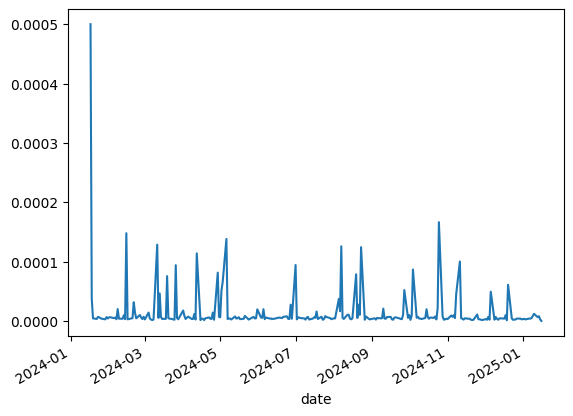

In [18]:
C_t.plot()

In [19]:
C_t.to_csv('./data/temp/forStocks/costs/Costs_CVaR_MinRisk.csv')

# 投资组合价值计算

In [20]:
# 计算投资组合的收益率R_t
R_t = np.log(1-C_t.values) + (np.log(Y_t.values) * W_0.values).sum(1)

In [21]:
R_t = pd.DataFrame(R_t)
R_t.index = Y_t.index

In [22]:
# R_t.plot()

In [23]:
# 把投资组合收益率转为资产价格
price = np.exp(R_t.cumsum())
price.rename(columns={0:'CVaR_MinRisk'},inplace=True)

<Axes: xlabel='date'>

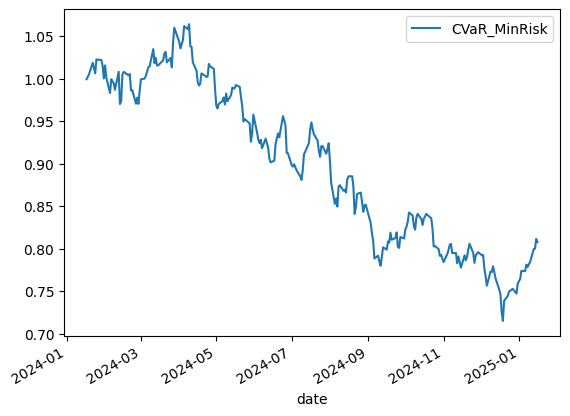

In [24]:
price.plot()

In [25]:
price.to_csv('./data/temp/forStocks/values/Values_CVaR_MinRisk.csv')

# 其它

In [26]:
W_0.sort_index(axis=1,inplace=True)

<Axes: xlabel='date'>

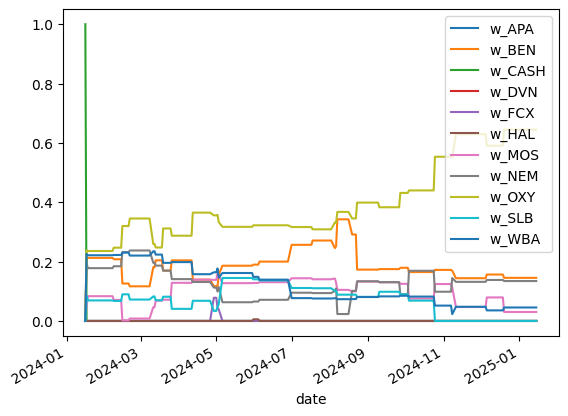

In [27]:
W_0.plot()

In [28]:
W_0.to_csv('./data/temp/forStocks/weights/Weights_CVaR_MinRisk.csv') 

In [29]:
from util import sharpe, sortino, MDD, MDD1, calmar, other_metrics

In [30]:
print("每日平均收益率(log return)：",np.mean(R_t.values))

每日平均收益率(log return)： -0.0008469560521496399


In [31]:
print('年化sharpe比率:',sharpe(R_t.values)) 

年化sharpe比率: -1.0796543627893804


In [32]:
print('年化sortino比率：',sortino(R_t.values))

年化sortino比率： -1.6612142800524128


In [33]:
print('最大回撤',MDD1(price['CVaR_MinRisk']))

最大回撤 0.3282884078044944


In [34]:
print('Calmar比率:',calmar(R_t.values))

Calmar比率: -0.650138476009835


In [35]:
other_metrics(R_t.values)

平均年化收益率（annual average return）： -0.21343292514170925
年化波动率（annual variance）： 0.19768475782575803
投资胜率（percentage of positive trade returns）： 0.49603174603174605
平均益损比（ratio between positive and negative returns）: 0.8543322348601088


In [36]:
# 保存优化指标到CSV文件
import os

# 确保目录存在
os.makedirs('./data/temp/forStocks/metrics', exist_ok=True)

# 重新计算各项指标以获取数值
annual_return = np.mean(R_t.values) * 252  # 年化收益率
annual_std = np.std(R_t.values) * np.sqrt(252)  # 年化波动率
sharpe_ratio = sharpe(R_t.values)
sortino_ratio = sortino(R_t.values)
mdd_value = MDD1(price['CVaR_MinRisk'])
calmar_ratio = calmar(R_t.values)

# 计算投资胜率和平均益损比
positive_returns = R_t.values[R_t.values > 0]
negative_returns = R_t.values[R_t.values < 0]
pct_positive = len(positive_returns) / len(R_t.values)
avg_positive = np.mean(positive_returns) if len(positive_returns) > 0 else 0
avg_negative = np.mean(negative_returns) if len(negative_returns) > 0 else 0
avg_ratio = abs(avg_positive / avg_negative) if avg_negative != 0 else 0

# 创建指标字典，按要求的顺序排列
metrics_dict = {
    'E(R)': round(annual_return, 4),
    'Std(R)': round(annual_std, 4),
    'Sharpe': round(sharpe_ratio, 4),
    'Sortino': round(sortino_ratio, 4),
    'MDD': f"{round(mdd_value * 100, 2)}%",
    'Calmar': round(calmar_ratio, 4),
    '%of+Ret': round(pct_positive, 4),
    '(Ave.P)/(Ave.L)': round(avg_ratio, 4)
}

# 转换为DataFrame
metrics_df = pd.DataFrame([metrics_dict])

# 保存到CSV文件
metrics_df.to_csv('./data/temp/forStocks/metrics/metrics_CVaR_MinRisk.csv', index=False)

print("指标已保存到 './data/temp/forStocks/metrics/metrics_CVaR_MinRisk.csv'")

指标已保存到 './data/temp/forStocks/metrics/metrics_CVaR_MinRisk.csv'
